In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,[m,n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G,[m,n_H*n_W,n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C,a_G)))/(4*n_H*n_W*n_C)
    
    return J_content

### Computing the style cost

In [3]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A,A,transpose_b=True)
    
    return GA

In [4]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*(n_C*n_C)*(n_H*n_W)**2)

    return J_style_layer

In [5]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [7]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha*J_content + beta*J_style
    
    return J

In [8]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Let's load, reshape, and normalize our "content" image

In [9]:
content_image = scipy.misc.imread("images/louvre.jpg")
content_image = reshape_and_normalize_image(content_image)

C:\Users\samud\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Let's load, reshape and normalize our "style" image

In [10]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

C:\Users\samud\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


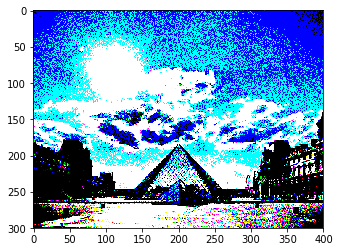

In [11]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [12]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [13]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [14]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [15]:
J = 10*J_content+40*J_style

In [16]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [17]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model["input"])
 
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [18]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5067715000.0
content cost = 7890.568
style cost = 126690904.0
Iteration 20 :
total cost = 947637060.0
content cost = 15228.11
style cost = 23687120.0
Iteration 40 :
total cost = 487795070.0
content cost = 16687.877
style cost = 12190705.0
Iteration 60 :
total cost = 314094340.0
content cost = 17492.377
style cost = 7847986.0
Iteration 80 :
total cost = 230403060.0
content cost = 17859.477
style cost = 5755611.5
Iteration 100 :
total cost = 182809680.0
content cost = 18070.727
style cost = 4565724.5
Iteration 120 :
total cost = 151100030.0
content cost = 18213.514
style cost = 3772947.8
Iteration 140 :
total cost = 128701944.0
content cost = 18344.434
style cost = 3212962.5
Iteration 160 :
total cost = 111785210.0
content cost = 18425.783
style cost = 2790023.8
Iteration 180 :
total cost = 98373680.0
content cost = 18493.088
style cost = 2454718.8


array([[[[ -40.1734    ,    1.1943548 ,   11.309094  ],
         [ -37.816788  ,   -2.0679083 ,   27.02414   ],
         [ -30.125885  ,    9.485695  ,    7.0548606 ],
         ...,
         [ -14.058193  ,  -13.462543  ,    0.41568044],
         [  -9.507553  ,  -14.078707  ,   20.294468  ],
         [ -11.918096  ,  -12.0543375 ,   37.446682  ]],

        [[ -33.51745   ,   -6.8502436 ,   25.070057  ],
         [ -72.60222   ,  -24.161974  ,  -21.529455  ],
         [ -54.050694  ,  -33.26314   ,  -27.931173  ],
         ...,
         [  -8.055653  ,  -31.869362  ,   -1.2147967 ],
         [  -9.659846  ,    1.0284381 ,   18.919708  ],
         [  -9.465736  ,   -6.6386404 ,   22.139307  ]],

        [[ -72.286095  ,  -35.06074   ,   13.962226  ],
         [ -60.79928   ,  -41.492516  ,  -19.30686   ],
         [ -59.523117  ,  -39.17598   ,  -18.361565  ],
         ...,
         [   4.5866113 ,    3.3267035 ,  -11.083567  ],
         [  -3.4971738 ,   -6.450186  ,   -9.437682  ],
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


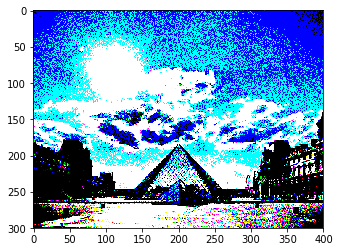

In [19]:
imshow(generated_image[0])